<a href="https://colab.research.google.com/github/siryang2006/-/blob/master/LLM%E5%AD%A6%E4%B9%A0_%E4%BB%8E0%E6%9E%84%E5%BB%BA%E4%B8%80%E4%B8%AA%E8%87%AA%E5%B7%B1%E7%9A%84LLM_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 动手学习-从0构建自己的LLM

In [1]:

import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd
import urllib.request

In [2]:
  # 创建一个字典用于存储config
MASTER_CONFIG = {
    # 参数放这里
}

In [3]:
# 下载一个吴承恩版本的西游记原文数据集
url = "https://raw.githubusercontent.com/mc112611/PI-ka-pi/main/xiyouji.txt"
file_name = "xiyouji.txt"
urllib.request.urlretrieve(url, file_name)

('xiyouji.txt', <http.client.HTTPMessage at 0x7d64d6052660>)

In [4]:
# 读数据
lines = open("xiyouji.txt", 'r').read()

# 创建简易版词表（字符级）
vocab = sorted(list(set(lines)))

# 查看词表前n个字符
head_num=50
print('词表前{}个:'.format(head_num), vocab[:head_num])

print('词表大小:', len(vocab))

词表前50个: ['\n', ' ', '!', '"', '#', '*', ',', '.', '—', '‘', '’', '“', '”', '□', '、', '。', '《', '》', '一', '丁', '七', '万', '丈', '三', '上', '下', '不', '与', '丑', '专', '且', '丕', '世', '丘', '丙', '业', '丛', '东', '丝', '丞', '丢', '两', '严', '丧', '个', '丫', '中', '丰', '串', '临']
词表大小: 4325


In [5]:
# 将词表编码成为数字，普通的整数
itos = {i: ch for i, ch in enumerate(vocab)}

# 双向映射
stoi = {ch: i for i, ch in enumerate(vocab)}

In [6]:
# 编码器（青春版）
def encode(s):
    return [stoi[ch] for ch in s]

# 解码器（青春版）
def decode(l):
    return ''.join([itos[i] for i in l])

# 来试一下这个高端的编解码器
decode(encode("悟空"))
encode("悟空")
# cing~ 效果拔群！

[1318, 2691]

In [7]:
# 对全文进行编码，并映射成为tensor
dataset = torch.tensor(encode(lines), dtype=torch.int16)

# 看一下形状，实际上就是多少个字符，一共65万个字符
print(dataset.shape)
print(dataset)

torch.Size([658298])
tensor([   0, 4319, 1694,  ...,   12,    0,    0], dtype=torch.int16)


In [8]:
# 构建batch
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    # 切分训练集，验证集，测试集，比例为，训练80%，验证10%，测试10%
    train = data[:int(0.8 * len(data))]
    val = data[int(0.8 * len(data)): int(0.9 * len(data))]
    test = data[int(0.9 * len(data)):]

    # 将全部的训练数据作为batch，验证集，测试集也换个变量存储（单纯为了方便看）
    batch_data = train
    if split == 'val':
        batch_data = val
    if split == 'test':
        batch_data = test

    # 这里需要学习torch.randint，生成大小为batch_size，内部数值为随机整数的tensor。生成随机数数值域为[0,训练集字符数量-滑动窗口大小-1]之间的整数
    # 详情可以参考官方文档，或者这个博客：https://blog.csdn.net/qq_41813454/article/details/136326473
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    # print('ix输出:')
    # print(ix)


    # 这里需要学习torch.stack，执行操作类似于python的zip关键字，只不过操作对象是tensor张量，指定任意维度的张量进行组合
    # 详情参考官方文档，或者这个博客：https://blog.csdn.net/dongjinkun/article/details/132590205

    # 这里x作为特征，y作为预测值，因为文本生成任务是根据前n个字符，去推理后面的1个字符，因此y的构造会使窗口在保持原大小的基础上向后移一位
    # 通过滑动窗口，对batch_data中的训练数据，进行随机取样，相当于随机选择训练数据。
    # 在原65万多个字符中，随机选取一个字符作为开始，并以这个开始点，向后选取滑动窗口个数的字符，作为训练数据，向后移一位就是其目标值。  因此ix的构造不能超出index。
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()

    # 返回特征值，目标值
    return x, y

In [9]:
# 根据上面构造的get_batchs()函数，更新参数字典。
MASTER_CONFIG.update({
    'batch_size': 8,          # 不解释
    'context_window': 16,      # 滑动窗口采样，设置采样大小
    'vocab_size':4325         # 咱们的西游记数据集，一共包含4325个不重复的汉字，标点符号
})

In [10]:
# 获取训练数据
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# 因为是随机生成的采样，我们可以看一下数据，其中每个采样数据，来自于原文随机的起始点，每个元组为一个（x,y），可以观察每个x和y的首位去直观感受一下滑动窗口执行的操作
decoded_samples = [(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

print(decoded_samples)

[('真个是我们安身之处。里面且是宽阔', '个是我们安身之处。里面且是宽阔，'), ('放他出来，我把这两个孩儿还你，\n', '他出来，我把这两个孩儿还你，\n似'), ('盘，奉上老师父，\n各请一餐。此地', '，奉上老师父，\n各请一餐。此地八'), ('高处，只听喊一声：“开刀！”飕的', '处，只听喊一声：“开刀！”飕的把'), ('我家诈诱我的宝贝？着实无礼！可恶', '家诈诱我的宝贝？着实无礼！可恶！'), ('了，罢了！撞见那贩腌的妖怪也！”', '，罢了！撞见那贩腌的妖怪也！”众'), ('尊之不弃，降圣驾而临庭。俯求垂念', '之不弃，降圣驾而临庭。俯求垂念，'), ('！\n”三魔道：“哥啊，吃了杂碎也', '\n”三魔道：“哥啊，吃了杂碎也罢')]


In [11]:
# 构造一个评估函数
@torch.no_grad()
def evaluate_loss(model, config=MASTER_CONFIG):
    # 评估结果存储变量
    out = {}

    # 将模型置为评估模式
    model.eval()

    # 分别会在训练集和验证集里通过get_batchs()函数取评估数据
    for split in ["train", "val"]:

        losses = []

        # 评估10个batch
        for _ in range(10):
            # 拿到特征值（输入数据），以及目标值（输出数据）
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])

            # 把拿到的数据丢进模型，得到loss值
            _, loss = model(xb, yb)

            # 更新loss存储
            losses.append(loss.item())

        # 这里就是大家经常在控制台看到的 "train_loss"  "valid_loss"由来
        out[split] = np.mean(losses)

    # 评估完了，别忘了把模型再置回训练状态，下一个epoch还要继续训练呢
    model.train()

    return out

In [12]:
# 在进行分析LlaMa架构分析之前，我们从最简单的文本生成模型开始创建，然后在最简单的文本生成模型的基础上，把LlaMa的RSM，Rope等一点点添加进去。为此我们先：
# 创建一个有毛病的模型架构
# 分析一下这个架构（其实也没什么分析的）
class StupidModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        # embedding层，输入：词表大小，输出：维度大小
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])

        # 创建线性层用于捕捉特征关系
        # 下面突击检查：这玩意是不是隐藏层！线性层堆叠越多是不是越好！堆叠越多是不是更计算开销越大！
        # LlaMa使用的激活函数是SwiGLU，目前在这个斯丢匹德模型架构里面先用Relu
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # 这个命令可以背一下，或者复制粘贴到自己的学习笔记。 因为这行命令会直接帮你查看模型的参数量。
        # 否则要么自己手算，要么就是听别人讲某某模型 7B  20B  108B   有了这个命令，你就能直接查看你创建的模型参数量多少
        print("模型参数量：", sum([m.numel() for m in self.parameters()]))

In [13]:
# 为我们创建的小模型添加前向传播
class SimpleBrokenModel(nn.Module):
    # init里的跟上面一样，没变化
    def __init__(self, config=MASTER_CONFIG):
      super().__init__()
      self.config = config
      self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
      self.linear = nn.Sequential(
          nn.Linear(config['d_model'], config['d_model']),
          nn.ReLU(),
          nn.Linear(config['d_model'], config['vocab_size']),
      )



      # 添加前向传播函数
    def forward(self, idx, targets=None):
        # 实例化embedding层，输入映射为id的数据，输出嵌入后的数据
        x = self.embedding(idx)

        # 线性层承接embedding层输出的数据
        a = self.linear(x)

        # 对线性层输出的数据在最后一个维度，做softmax，得到概率分布
        logits = F.softmax(a, dim=-1)

        # 如果有目标值（也就是我们前面的y），则计算通过交叉熵损失计算loss结果。给输出的概率矩阵变个形状，再给目标值变个形状。  统一一下输入输出，然后计算loss。其中最后一维代表着一条数据。
        # 此处需要了解tensor.view()函数，带上几何空间想象力去想一下矩阵的形状。
        if targets is not None:

            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        # 如果没有目标值，则只返回概率分布的结果
        else:
            return logits

        # 查看参数量
        print("模型参数量：", sum([m.numel() for m in self.parameters()]))

In [14]:
# 这里我们设置这个模型为128维的embedding
MASTER_CONFIG.update({
    'd_model': 128,
})

# 实例化模型，传参
model = SimpleBrokenModel(MASTER_CONFIG)

# 再看看参数量
print("咱们的模型这么多参数量:", sum([m.numel() for m in model.parameters()]))
# 于是乎，我们创建了一个1128307个参数的模型，上面参数想怎么改，自己改！电脑不会爆炸！

咱们的模型这么多参数量: 1128037


In [15]:
# 获取训练的特征数据与目标数据
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# 扔进模型获取概率分布矩阵与loss
logits, loss = model(xs, ys)
loss

tensor(8.3722, grad_fn=<NllLossBackward0>)

In [16]:
# 更新参数，训练伦次，batch_size，log日志打印步长
MASTER_CONFIG.update({
    'epochs': 1000,
    'log_interval': 10,      # 每10个batch打印一次log
    'batch_size': 32,
})

# 实例化模型
model = SimpleBrokenModel(MASTER_CONFIG)

# 创建一个Adam优化器，基础知识，
optimizer = torch.optim.Adam(
    model.parameters(),      # 优化器执行优化全部的模型参数
)

Validation loss:  8.226290321350097


<Axes: >

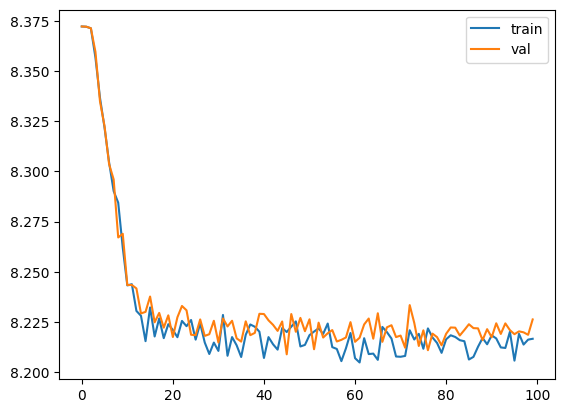

In [17]:
# 构建训练函数
def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    # loss存储
    losses = []

    # 训练时间记录开始时间
    start_time = time.time()

    # 循环训练指定epoch的轮数
    for epoch in range(config['epochs']):
        # 优化器要初始化啊，否则每次训练都是基于上一次训练结果进行优化，效果甚微
        optimizer.zero_grad()

        # 获取训练数据
        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])

        # 前向传播计算概率矩阵与loss
        logits, loss = model(xs, targets=ys)

        # 反向传播更新权重参数，更新学习率优化器
        loss.backward()
        optimizer.step()

        # 如果提供学习率调度器，那么学习率会通过调度器进行修改，比如学习率周期性变化，或者梯度减小，增加，具体策略需要综合考虑进行设置，详情自行查询，关键字：lr_scheduler
        if scheduler:
            scheduler.step()

        # 打印log
        if epoch % config['log_interval'] == 0:
            # 训练时间
            batch_time = time.time() - start_time

            # 执行评估函数，在训练集和验证集上计算loss
            x = evaluate_loss(model)

            # Store the validation loss
            losses += [x]

            # 打印进度日志
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")

            # 重置开始时间，用于计算下一轮的训练时间
            start_time = time.time()

            # 打印下一轮的学习率，如果使用了lr_scheduler
            if scheduler:
                print("lr: ", scheduler.get_lr())

    # 上面所有epoch训练结束，打印最终的结果
    print("Validation loss: ", losses[-1]['val'])

    # 返还每一步loss值的列表，因为我们要画图，返还的是loss迭代的图像
    return pd.DataFrame(losses).plot()

# 启动训练
train(model, optimizer)

上面那个训练框架存在一些问题。  回到前向传播的代码，也就是forward()中。 我们使用了 logits = F.softmax(a, dim=-1)   对线性层输出的结果做了一次概率分布的计算。  而loss的计算选择了交叉熵损失， 目标值的词表映射结果是整数，而模型输出的logits是概率矩阵。  为了使loss计算更精确，我们需要将softmax去除。  以保证交叉熵损失的计算效果更好。

In [18]:
# 拿掉softmax，logits改为获取最后一个线性层输出的结果，不进行softmax计算概率分布。
# 因此将这个架构取名为：不那么蠢的模型架构
class SimpleNotStupidModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
      super().__init__()
      self.config = config
      self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
      self.linear = nn.Sequential(
          nn.Linear(config['d_model'], config['d_model']),
          nn.ReLU(),
          nn.Linear(config['d_model'], config['vocab_size']),
      )
      print("Model parameters:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # 看这里，线性层直接输出结果，不转换为概率矩阵，只修改这里，其余不动。
        logits = self.linear(x)
        # print(logits.shape)

        if targets is not None:

            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        else:
            return logits
        print("Model parameters:", sum([m.numel() for m in self.parameters()]))

Model parameters: 1128037
Validation loss:  5.106809282302857


<Axes: >

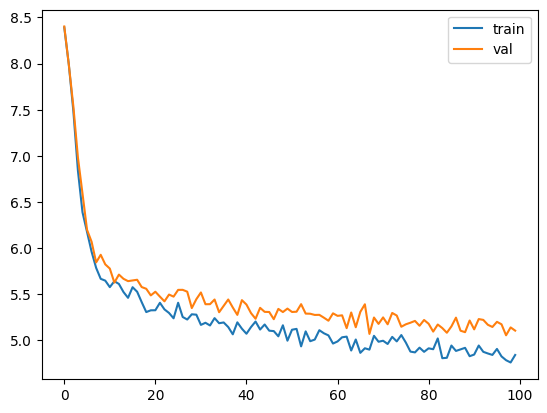

In [19]:
# 再来一次实例化各种功能，再启动一次训练
model = SimpleNotStupidModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

# loss开窍了，下降了很多

In [20]:
# 推理函数（输出结果就别纠结其效果了，权重都没保存，就是根据模型初始化生成的随机数组成的矩阵做的推理）
def generate(model, config=MASTER_CONFIG, max_new_tokens=20):
    # 生成随机数，作为输入数据,5行一列，代表输入5个字符。 这个地方可以自行替换其他随机数测试。
    idx = torch.zeros(5, 1).long()
    print(idx[:, -config['context_window']:])
    for _ in range(max_new_tokens):
        # 因为推理的时候，依赖后面的n个token，所以滑动窗口要从后往前选择输入数据的倒数几个token，这个是超过字符数量会对输入进行截断，只选取最后几个token：idx[:, -config['context_window']:]
        logits = model(idx[:, -config['context_window']:])
        # print(logits.size())
        # 得到模型输出的结果，进行解码，这里logits[:, -1, :]挺抽象的，实际上第一维度是输入的字符数，第二维度是时间步，第三维度是词表
        # 即，对每一步的解码结果，取最后一个时间步的数据，作为输出的数据。解码的过程是第一次解码，输入5个token，第二次解码依赖的是原来5个token的最后4个，加上上一步解码生成的一个，也是5个token，如此循环。
        last_time_step_logits = logits[:, -1, :]
        # print('last_time_step_logits')
        # print(last_time_step_logits.shape)
        # 计算概率分布
        p = F.softmax(last_time_step_logits, dim=-1)
        # print('p_shape')
        # print(p.shape)
        # 根据概率分布计算下一个token，这里使用 torch.multinomial做的是随机采样
        idx_next = torch.multinomial(p, num_samples=1)
        # print('idx_next_shape')
        # print(idx_next.shape)
        # 将新的idx通过张量拼接写入到解码序列中
        idx = torch.cat([idx, idx_next], dim=-1)
    # 使用之前定义的解码函数，将ID转换为汉字，我们得到的5行21列的数据，来源于每一个输入字符作为开始位置，生成20个字符。 因为5个输入都是0，在词表中编号为0的数据是'\n'。
    print(idx.shape)
    return [decode(x) for x in idx.tolist()]

generate(model)


tensor([[0],
        [0],
        [0],
        [0],
        [0]])
torch.Size([5, 21])


['\n好！\n是之摸引是我右开恼丹了！”\n富回口',
 '\n我之事哩，儿宝贝可以交\n慌了大王，披山\n',
 '\n是什么八戒道：“和尚，只是呢虎轻指非崖心',
 '\n了；上，诗住，拿了。想是神有蹲，甚，绰也',
 '\n阿九萦，扎众僧去带着头喷掌；有个妖道：“']

# 将LlaMa优化部分加入到上面的notStupidModel

需要做的有三部分:

  1.RMS_Norm

  2.ROPE

  3.SwiGLU

## RMSNorm
### RMSNorm快速了解

norm，做标准化，训练过程中的张量标准化操作，通过计算均值和方差，将样本进行归一化。
在大学课程《概率与统计》我们学过，样本的均值代表样本的特征，而方差代表离散程度。

因此，通过计算，让数据变为均值为0，方差为1的数据。 这样可以使数据服从标准的正态分布。

记得大学时候，老师讲这一段的时候，着重强调：“高斯分布，正态分布”，也可以叫自然分布，自然界的很多统计情况，几乎都满足高斯分布。 两边向中心靠拢，超过中心的，随着逐渐增大，会越来越少，没超过中心的，距离中心越远，数量也越来越少。而分布的众数永远都是在中间。 数学之美。

使用均值和方差计算数据的标准差，这样既保留了数据的异常值，同时维持数据的异常结构，这样可以稳定梯度，让梯度变化更稳定，减少梯度消失或者爆炸的问题，因为维持了异常结构，也能减少过拟合问题，增强泛化能力。

RMSNorm出来之前，广泛使用的batch_normlize，针对批次数据做标准化。标准化的数值是一个batch作为一个样本总体，计算其均值与方差。

而后，又出现了layer_norm，其是针对每个token的特征向量做归一化处理（不知道特征向量，请看本人之前的rope文章。应该可以理解token和特征向量的关系。）依旧需要计算均值和方差。


RMSNorm和layer_norm的主要区别在于RMSNorm不需要同时计算均值和方差两个统计量，而只需要计算均方根这一个统计量。在模型表现效果几乎与layer_norm持平的前提下，节省7%-64%的计算量。

猜想：  既然都平方根了，突然想起程序员之神，约翰卡马克的快速平方根倒数算法了。让所有人直呼waht the f**k的神来一笔。  当然，也有可能这么经典的数值计算方法已经被集成进了numpy。

RMS基本介绍差不多了，下面开始实现RMSNorm模块

In [21]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()

        # torch中register_parameter()功能为：向我们建立的网络module添加parameter
        # 因此，我们需要对pytorch官方封装好的RMSNorm功能模块添加一个可以训练参数的层，命名为scale，并初始化为形状为layer_shape，所有值为1的张量矩阵。
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        # 计算Frobenius范数（球某个矩阵中所有元素的平方和再开方得到，该范数用来衡量矩阵的大小，详情请百度）, RMS = 1/sqrt(N) * Frobenius
        # 具体来说，torch.linalg.norm(x, dim=(1, 2))计算了x在第1和第2维度上的范数。然后，将结果乘以x[0].numel() ** -.5。x[0].numel()表示x第一个元素（即x的第一行）的元素个数，** -.5表示求平方根的倒数。
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
        # print(ff_rms.shape)
        # 将ff_rms算子应用于输入的张量x，依据公式，做除法，因为输入向量x是三维的，因此需要对ff_rms进行升两维，也变成三维的张量。这样可以进行元素之间的计算。
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        # print(raw.shape)
        # 返回scale缩放后归一化的张量
        # print(self.scale[:x.shape[1], :].unsqueeze(0) * raw)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

In [22]:
class SimpleNotStupidModel_RMS(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
      super().__init__()
      self.config = config
      self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
      # 在这里，我们添加RMS层
      self.rms = RMSNorm((config['context_window'], config['d_model']))
      self.linear = nn.Sequential(
          nn.Linear(config['d_model'], config['d_model']),
          nn.ReLU(),
          nn.Linear(config['d_model'], config['vocab_size']),
      )
      print("Model parameters:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        # 在这里，添加实例化后的RMS层，承接Embedding层输出的张量
        x = self.rms(x)

        logits = self.linear(x)
        # print(logits.shape)

        if targets is not None:

            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        else:
            return logits
        print("Model parameters:", sum([m.numel() for m in self.parameters()]))

Model parameters: 1130085
Validation loss:  5.0823287010192875


<Axes: >

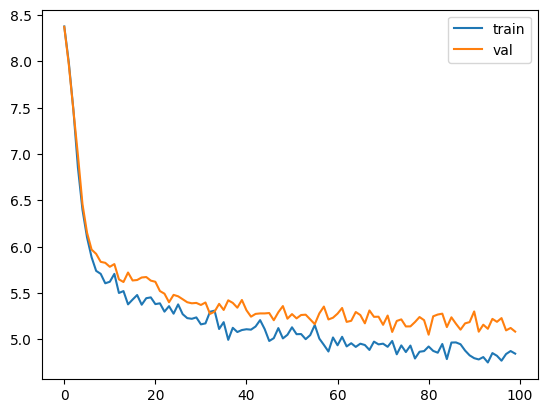

In [23]:
# 好啦，这样我们对原来的NotStupidModel添加了RMSNorm，现在执行一下看看
model = SimpleNotStupidModel_RMS(MASTER_CONFIG)

xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)

optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer)

# 在同样的训练超参数设置上，加入了RMSNorm的训练速度明显加快。

## 增加RoPE

具体原理请参考俺的上一篇文章。

In [24]:
def get_rotary_matrix(context_window, embedding_dim):
    # 初始化一个0填充，形状为（context_window, embedding_dim, embedding_dim）的张量矩阵，其中context_window为token数量，后面两个embedding_dim组成正方形矩阵，与后面的attention计算对齐格式
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)

    # 遍历每一个位置的token
    for position in range(context_window):
        # 还记得我的上一篇文章中说的，对于特征，两两组合吗，因此需要循环的次数为embedding_dim除以2
        for i in range(embedding_dim // 2):
            # 设置θ值，采样频率，或者说旋转频率，旋转角都可以，除以embedding_dim防止梯度问题。
            theta = 10000. ** (-2. * (i - 1) / embedding_dim)
            # 根据欧拉公式，计算旋转的角度，分别有sin 和cos，将计算拉到复数空间，并将旋转角度应用在上面的0填充的矩阵
            m_theta = position * theta
            R[position, 2 * i, 2 * i] = np.cos(m_theta)
            R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
            # 得到的结果是旋转位置编码矩阵，到这里还没覆盖到attention
    return R

## 接下来创建注意力机制

In [25]:
# 此为单头注意力机制
class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # 计算Q权重矩阵
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # 计算K权重矩阵
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # 计算V权重矩阵
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)
        # 获得旋转位置编码矩阵，接下来会覆盖Q和K权重矩阵
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])


    # 这里将上一个代码块中实现的创建旋转位置编码的功能函数原封不动的拿过来
    def get_rotary_matrix(context_window, embedding_dim):
        # 初始化一个0填充，形状为（context_window, embedding_dim, embedding_dim）的张量矩阵，其中context_window为token数量，后面两个embedding_dim组成正方形矩阵，与后面的attention计算对齐格式
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)

        # 遍历每一个位置的token
        for position in range(context_window):
            # 还记得我的上一篇文章中说的，对于特征，两两组合吗，因此需要循环的次数为embedding_dim除以2
            for i in range(embedding_dim // 2):
                # 设置θ值，采样频率，或者说旋转频率，旋转角都可以，除以embedding_dim防止梯度问题。
                theta = 10000. ** (-2. * (i - 1) / embedding_dim)
                # 根据欧拉公式，计算旋转的角度，分别有sin 和cos，将计算拉到复数空间，并将旋转角度应用在上面的0填充的矩阵
                m_theta = position * theta
                R[position, 2 * i, 2 * i] = np.cos(m_theta)
                R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
                # 得到的结果是旋转位置编码矩阵，到这里还没覆盖到attention
        return R

    def forward(self, x, return_attn_weights=False):
        # 前向传播时，输入矩阵的形状为(batch, sequence length, dimension)

        b, m, d = x.shape  # batch size, sequence length, dimension

        # 线性变换Q,K,V
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        # 将旋转位置编码应用于Q和K，其中torch.bmm为矩阵做外积，transpose是转置，对Q矩阵转置，并与旋转位置编码做外积，再转置回原状，Q便应用了旋转位置编码。
        # 考虑到输入文本的长度，因此对位置编码矩阵在第一维度做截断，因为长了也没用，与文本长度一样。
        q_rotated = (torch.bmm(q.transpose(0, 1), self.R[:m])).transpose(0, 1)
        # 同理对K也应用旋转位置编码进行覆盖
        k_rotated = (torch.bmm(k.transpose(0, 1), self.R[:m])).transpose(0, 1)

        # 对注意力机制点积进行等比例缩放，防止attention张量过长引发梯度爆炸，对应
        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p=0.1, is_causal=True
        )
        # 如果return_attn_weights参数置为1，则需要对attention进行掩码，因为在学习的时候，希望模型能依据前n个token去预测token，而不是开卷考试。
        if return_attn_weights:
            # 创建注意力掩码矩阵，其中torch.tril函数为：对于矩阵，取左下三角，剩下的都置0
            attn_mask = torch.tril(torch.ones((m, m)), diagonal=0)
            # 计算注意力机制的权重矩阵，并对最后一维度做归一化，（突击检查）为什么是最后一维！因为最后一维度是每个token的特征向量！
            attn_weights = torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d) + attn_mask
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights

        return activations

In [26]:
# 单头注意力机制实现完毕，下面实现多头注意力机制
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # 一个注意力机制头对象构建完毕了，多头的，首先多次创建这个对象。生成多个注意力机制头，塞到一个列表里。
        self.heads = nn.ModuleList([
            RoPEMaskedAttentionHead(config) for _ in range(config['n_heads'])
        ])
        # 在模型结构上，创建一个线性层（隐藏层），用于线型输出注意力机制头输出的张量矩阵，寻找多头之间的特征，但是更主要的是，x经过多头计算后形状改变了，创建线性层，让张量矩阵变回原来输入的形状。
        # 同时为了防止过拟合，使用随机神经元失活，比率0.1
        # 线性层输入形状：注意力机制的头数，乘以矩阵的维度，关联到俺的上一篇文章，就是key矩阵，在多头之间共享权重，减少计算的思维。 输出为：模型的embedding维度数
        self.linear = nn.Linear(config['n_heads'] * config['d_model'], config['d_model'])
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # 输入矩阵形状x： (batch, sequence length, dimension)

        # 每一个注意力机制头，都传入X进行计算。（这个地方开启并行执行会不会快一些，但是不知道pytorch是不是自动调用并行）
        heads = [h(x) for h in self.heads]
        # 输入张量x经过多个头计算attention（同时，attention是已经覆盖了RoPE的），重新拼接成新的矩阵，重新放入变量x。到这里你应该觉得：那矩阵形状不就变了吗
        x = torch.cat(heads, dim=-1)

        # 这不，线性层的作用来了
        x = self.linear(x)

        # 随机失活一下，防止过拟合
        x = self.dropout(x)
        return x

In [27]:
# Llama 32个注意力机制头，我们来8个吧

MASTER_CONFIG.update({
    'n_heads': 8,
})

In [28]:
# 我们已经创建完了所需要的算子，  现在积木已创建完毕，将这些积木组合起来！！！！
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Embedding层
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])

        # RMSNorm层
        self.rms = RMSNorm((config['context_window'], config['d_model']))

        # 旋转位置编码器+注意力机制
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        # 线性层+激活函数变为非线性输出！
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
        )

        # 最终的输出，因为需要解码，因为输出的维度与词表大小统一！！！
        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        print("model params:", sum([m.numel() for m in self.parameters()]))
    # 前向传播
    def forward(self, idx, targets=None):
        # embedding，不解释
        x = self.embedding(idx)
        # 归一化数值，不解释
        x = self.rms(x)
        # 相加，解释一下，因为attention是要覆盖到原矩阵的，想象两个形状一样的矩阵为两张纸，左手一张纸，右手一张纸，双手合十，啪！覆盖。 使用加算，就是将两个矩阵中的元素按位置相加！直接覆盖值！
        x = x + self.rope_attention(x)
        # 再归一化！
        x = self.rms(x)
        # 因为直接计算归一化的数值可能出现梯度问题，因此把归一化的值作为修正系数，再覆盖！
        x = x + self.linear(x)
        # 到这里，才是最终输出vocab数量的神经元输出！！！！！！
        logits = self.last_linear(x)

        # 训练阶段有目标值
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        # 验证或者推理阶段，目标值y没有！只有结果，没有loss！
        else:
            return logits

model params: 1654501
Validation loss:  5.044248819351196


<Axes: >

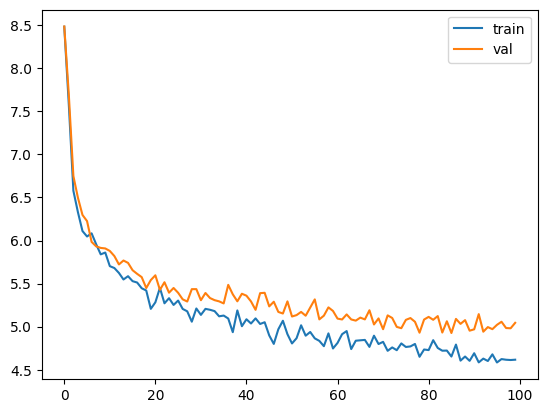

In [29]:
# 再跑一下！
model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)
# loss下降了百分之0.1！

## SwiGLU实现

将swish和glu结合起来。这两个激活函数单独拿出来都很强，结合起来。

这玩意挺玄学，说它不好吧，但是这玩意确实比relu这败家子保留更多语义特征参数，不至于某个权重突然到了小于0的区间，然后糊里糊涂的消失。说它好吧，它的计算量确实挺大。   

swish用了sigmoid，GLU用了门控结构（门控结构思想，可以学习一下RNN,GRU,LSTM什么的）

In [30]:
class SwiGLU(nn.Module):

    def __init__(self, size):
        super().__init__()
        # 定义一个门控的线性层，输入输出都是门控结构的尺寸
        self.linear_gate = nn.Linear(size, size)
        # 门控结构主干线性层
        self.linear = nn.Linear(size, size)
        # 初始化一个随机数作为beta系数
        self.beta = torch.randn(1, requires_grad=True)

        # nn.Parameter用于指定某一层参数为可学习的，即本来不能通过训练更改参数，现在变成了可以经过训练来更新的参数。
        self.beta = nn.Parameter(torch.ones(1))
        # 将随机数beta指定为一个名为beta的神经网络层
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        # Swish门控但愿的计算：（从括号里开始）对于原始输入的数据张量，经过线性变换乘以beta系数，再经过sigmoid变换为0-1之间的值，再乘以原数据经过门控线性变换。总的来说，线型输出经过非线性变换，再应用到线性变换的结果，元素按位置相乘，修正原本数据张量，就是这个门控结构做的事情。
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        # 将门控结构输出的值再按位乘以线型输出的原数据张量
        # 为啥这么做，我不知道，但是论文复现的代码就是这样滴，有兴趣可以研究一下，我没研究过。
        out = swish_gate * self.linear(x)
        return out

In [31]:
# 再将swiglu添加进上面的模型
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEMaskedMultiheadAttention(config)
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            # 在这里，增加了SwiGLU层
            SwiGLU(config['d_model']),
        )
        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x)
        x = x + self.rope_attention(x)
        x = self.rms(x)
        x = x + self.linear(x)
        logits = self.last_linear(x)

        if targets is not None:
            # Calculate cross-entropy loss if targets are provided
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model params: 1687526
Validation loss:  5.046039152145386


<Axes: >

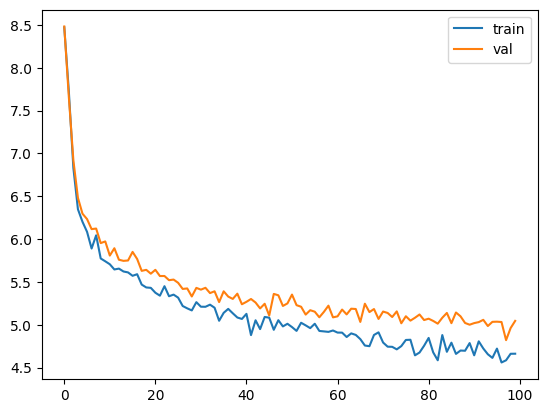

In [32]:
# 一二三四！再来一次！
model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

In [33]:
# OK！ 现在我们更新一下，隐藏层维度堆叠多少层，我们先来4层尝尝咸淡！！！！
MASTER_CONFIG.update({
    'n_layers': 4,
})

In [34]:
# 现在我们拥有了所有的算子，RMS，ROPE,SWIGLU，我们搭建我们的LlaMa！ 首先实现LlaMa的功能块，然后堆叠。
# 功能没什么好讲的，如果仔细看到了这里，下面的每一行代码都难不住你。
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.attention = RoPEMaskedMultiheadAttention(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):

        x = self.rms(x)
        x = x + self.attention(x)

        x = self.rms(x)
        x = x + self.feedforward(x)
        return x

In [35]:
# 看一下我们的超参数字典
MASTER_CONFIG

{'batch_size': 32,
 'context_window': 16,
 'vocab_size': 4325,
 'd_model': 128,
 'epochs': 1000,
 'log_interval': 10,
 'n_heads': 8,
 'n_layers': 4}

In [36]:
# 用config字典，创建llama的功能块
block = LlamaBlock(MASTER_CONFIG)

# 生成一条随机数据，丢到这个llama功能块里，看一下是不是有bug
random_input = torch.randn(MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model'])

# 执行以下看看输出
output = block(random_input)
output.shape

torch.Size([32, 16, 128])

In [37]:
# 现在，我们组装LlaMa
from collections import OrderedDict
class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Embedding不解释
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])
        # 根据传入的堆叠层数，创建Llama功能块，注意OrderedDict为一种特殊类型的字典数据，保留字典写入的顺序，先插入的数据在前，后插入的数据在后。
        # 这里，我们将llama的功能块堆叠4层
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )
        # FFN层，包含：线性层、激活函数非线性变换、再用线性层输出最终解码数值。
        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # 看看咱们的大模型多少参数！
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        # embedding嵌入
        x = self.embeddings(idx)
        # Llama模型计算
        x = self.llama_blocks(x)
        # FFN计算，得到logits
        logits = self.ffn(x)

        # 推理阶段没有目标值，只输出结果
        if targets is None:
            return logits
        # 训练阶段，有目标值，需要输出结果，以及loss，用于反向传播更新权重！
        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

model params: 3465066
Validation loss:  5.277489757537841


<Axes: >

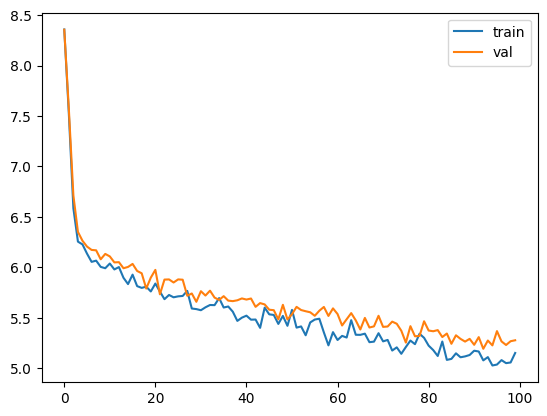

In [38]:
# 开始训练咱们的Llama
llama = Llama(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
logits, loss = llama(xs, ys)
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer)

In [39]:
# 练它一万轮！有条件的开启，本厮实在是不愿意等了。
MASTER_CONFIG.update({
    'epochs': 10000,
})

#train(llama, optimizer, scheduler=None, config=MASTER_CONFIG)

In [40]:
# 再看一下推理效果（实际上也没什么效果-。-）
# 别忘了generate里面的输入数据是咱们弄的5个0，如果替换为encode之后的数也是可以的！组成列表，转换tensor，这个应该没问题的吧~
generated_text = generate(llama, MASTER_CONFIG, 500)[0]
print(generated_text)

tensor([[0],
        [0],
        [0],
        [0],
        [0]])
torch.Size([5, 501])

前仔细空

妈麻，只出出入虫静，祝叶字，’西
路，悟初中负翠，你睁住面来东香扫：快的水。唐僧，等马就枚住碾北，且
去，自喳方令老事愁来！罢被他不要方图，暴的
老，原你看信果面处，急听
从上慈来，我架滩货不的情正师徒不脱
地诸？”老妖者正在人不识的，上举手僧主居。你听手巍他悲庄官实帝母还女说处怎子里婆上话不纵马侄见是戈毒，无个当四略水陋盔耳性，须见钯水焰磨；别三年开服，递降没多左，就得恨平光。
却只见宣巍
弄变问，自见美。八戒，寻启着皮剑，赛虫着二魔将。不来死头，教那徒耍与那人！我和有来成，我已时了。”八个大圣道：“西你不有不快！”些生一了
唐僧，兄瞒不住人马后你的丁么师父，但听天寺一顿门，骂水竹难菩萨。那怪旁活影，刀子法唐
太宫大太躬些，砍下征物。那呆子摆慧降两班惑，但将近乱钯也罢。妖婆错筑冷，举而定惊呵性，蟹得找定着，变游了素子地把，俱而肚入柱，将了与师师的，弄碍好低奶汉沙僧，
来是我父个有他说高壳了，拘作几是一个蕉儿跳彩多生池，无搭，通难身烘妖当，起芽气善也，出崖行
雄，诸是扯也早叨斗圣，徒说：你师兄能外子隔，掳买要拜，却只时施拿来，破脱救！：怎么是罢力，看赶何
你？”太徒弟是些问


In [41]:
# 下面是测试集跑一下
# 获取测试集的特征值和目标值
xs, ys = get_batches(dataset, 'test', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

# 丢进Llama获取loss
logits, loss = llama(xs, ys)

print(loss)
# 4.7326！

tensor(5.7099, grad_fn=<NllLossBackward0>)


model params: 3465066


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


lr:  [0.0009999457184159408]
lr:  [0.0009961510274583004]
lr:  [0.0009869757772816292]
lr:  [0.0009725204933511963]
lr:  [0.0009529435502760634]
lr:  [0.0009284594366176498]
lr:  [0.0008993364049014041]
lr:  [0.0008658935325782156]
lr:  [0.0008284972261358946]
lr:  [0.0007875572066618724]
lr:  [0.0007435220208394261]
lr:  [0.0006968741265588948]
lr:  [0.0006481246069855613]
lr:  [0.0005978075709959357]
lr:  [0.0005464743013294258]
lr:  [0.0004946872145648923]
lr:  [0.00044301369909075325]
lr:  [0.00039201989856974814]
lr:  [0.0003422645089892466]
lr:  [0.0002942926572257539]
lr:  [0.0002486299281339155]
lr:  [0.0002057766054928797]
lr:  [0.00016620218969383484]
lr:  [0.00013034025177986015]
lr:  [9.85836791664324e-05]
lr:  [7.128036241775617e-05]
lr:  [4.872936226262451e-05]
lr:  [3.117756953567661e-05]
lr:  [1.8816750064937722e-05]
lr:  [1.1779739336260682e-05]
lr:  [1.0054282328142978e-05]
lr:  [1.396862020283371e-05]
lr:  [2.3138198807489664e-05]
lr:  [3.7591595433673565e-05]
lr:  [

<Axes: >

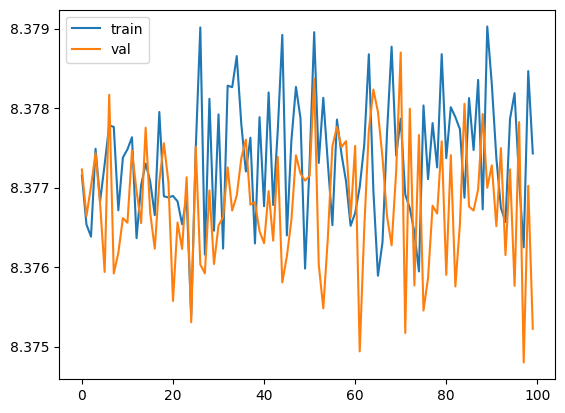

In [42]:
# 还有优化的点哦，别忘了optimizer！以及学习率调度器！
# 调整参数再来一次！

MASTER_CONFIG.update({
    "epochs": 1000
})

# 学习率优化器选择余弦退火
llama_with_cosine = Llama(MASTER_CONFIG)

llama_optimizer = torch.optim.Adam(
    llama.parameters(),
    betas=(.9, .95),
    weight_decay=.1,
    eps=1e-9,
    lr=1e-3
)
# 余弦退火学习率优化器，让学习率逐渐减小，在结束时达到最低值。 详细可以百度，这种文章很多。
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(llama_optimizer, 300, eta_min=1e-5)

# 跑一下！
train(llama_with_cosine, llama_optimizer, scheduler=scheduler)

In [43]:
# 保存你的模型！

torch.save(llama, 'llama_model.pth')


torch.save(llama.state_dict(), 'llama_model_params.pth')

## 当然了，也可以换一种方式保存，并加载推理

In [44]:
# 保存模型权重
model_save_path = "./hf_model_save/pytorch_model.bin"
torch.save(llama_with_cosine.state_dict(), model_save_path)

RuntimeError: Parent directory ./hf_model_save does not exist.

In [ ]:
# 生成一个config文件
import json

config_save_path = "./hf_model_save/config.json"
with open(config_save_path, 'w') as f:
    json.dump(MASTER_CONFIG, f)

In [ ]:
# 保存optimizer和学习率调度器的状态，方便继续微调
optimizer_save_path = "./hf_model_save/optimizer.pt"
torch.save(llama_optimizer.state_dict(), optimizer_save_path)

scheduler_save_path = "./hf_model_save/scheduler.pt"
torch.save(scheduler.state_dict(), scheduler_save_path)


In [ ]:
# 接下来是加载模型
llama_with_cosine = Llama(MASTER_CONFIG)

# 加载模型权重
model_save_path = "./hf_model_save/pytorch_model.bin"
llama_with_cosine.load_state_dict(torch.load(model_save_path))

# 设置为评估模式
llama_with_cosine.eval()

In [ ]:
# 加载优化器和学习率调度器
llama_optimizer.load_state_dict(torch.load(optimizer_save_path))
scheduler.load_state_dict(torch.load(scheduler_save_path))


In [ ]:


# 进行推理
output = generate(llama_with_cosine, MASTER_CONFIG)
print(output)


## 接下来可以整点花活儿，比如：部署一个异步的远程服务

In [ ]:
!pip install fastapi uvicorn



In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import torch
import torch.nn.functional as F

# 初始化 FastAPI
app = FastAPI()

# 模型加载
model_path = "./hf_model_save/pytorch_model.bin"
model = Llama(MASTER_CONFIG)
model.load_state_dict(torch.load(model_path))
model.eval()

class InputData(BaseModel):
    idx: list

@app.post("/generate/")
async def generate(model, config=MASTER_CONFIG, max_new_tokens=20):
    # 生成随机数，作为输入数据,5行一列，代表输入5个字符。 这个地方可以自行替换其他随机数测试。
    idx = torch.zeros(5, 1).long()
    print(idx[:, -config['context_window']:])
    for _ in range(max_new_tokens):
        # 因为推理的时候，依赖后面的n个token，所以滑动窗口要从后往前选择输入数据的倒数几个token，这个是超过字符数量会对输入进行截断，只选取最后几个token：idx[:, -config['context_window']:]
        logits = model(idx[:, -config['context_window']:])
        # print(logits.size())
        # 得到模型输出的结果，进行解码，这里logits[:, -1, :]挺抽象的，实际上第一维度是输入的字符数，第二维度是时间步，第三维度是词表
        # 即，对每一步的解码结果，取最后一个时间步的数据，作为输出的数据。解码的过程是第一次解码，输入5个token，第二次解码依赖的是原来5个token的最后4个，加上上一步解码生成的一个，也是5个token，如此循环。
        last_time_step_logits = logits[:, -1, :]
        # print('last_time_step_logits')
        # print(last_time_step_logits.shape)
        # 计算概率分布
        p = F.softmax(last_time_step_logits, dim=-1)
        # print('p_shape')
        # print(p.shape)
        # 根据概率分布计算下一个token，这里使用 torch.multinomial做的是随机采样
        idx_next = torch.multinomial(p, num_samples=1)
        # print('idx_next_shape')
        # print(idx_next.shape)
        # 将新的idx通过张量拼接写入到解码序列中
        idx = torch.cat([idx, idx_next], dim=-1)
    # 使用之前定义的解码函数，将ID转换为汉字，我们得到的5行21列的数据，来源于每一个输入字符作为开始位置，生成20个字符。 因为5个输入都是0，在词表中编号为0的数据是'\n'。
    print(idx.shape)
    return [decode(x) for x in idx.tolist()]


In [ ]:
# 在colab里启动还是挺麻烦的。  建议把所有代码整理一下，在服务器，或者个人电脑里运行
import nest_asyncio
import uvicorn

nest_asyncio.apply()

# 启动 FastAPI 应用
uvicorn.run(app, host="0.0.0.0", port=8000)


In [ ]:
# 服务部署成功后，可以发送请求测试效果
import requests

input_data = {"idx": [[0]]}  # 根据需求提供输入数据
response = requests.post("http://localhost:8000/generate/", json=input_data)
print(response.json())
